# Multi-task learning: using uncertainty weighted loss 

Multi-task learning is popular in many deep learning applications, for example, in object detection, the network performs both classification and localization for each object. As a result, the final loss will be a combination of classification loss and regression loss. The most frequent way of combining two losses is by simply adding them together. 

$ loss_{total} = loss_1 + loss_2 $


However, problem emerges when the two losses are on different numerical scale. To resolve this issue, people usually manually design/experiemnt the best weight, which is very time consuming and computationally expensive.

$ loss_{total} = w_1loss_1 + w_2loss_2 $

[This paper](https://arxiv.org/abs/1705.07115) presents an interesting idea of making the weight w1 and w2 as trainable parameters based on uncertainty of each task, such that the network can dynamically focus more on the task with higher uncertainty.

In [1]:
import os
import tempfile

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import fastestimator as fe
from fastestimator import RecordWriter
from fastestimator.architecture.uncertaintyloss import UncertaintyLoss
from fastestimator.architecture.unet import UNet
from fastestimator.dataset import cub200
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, MatReader, Reshape, Resize
from fastestimator.op.tensorop import Augmentation2D, BinaryCrossentropy, Loss, Minmax, ModelOp, Rescale, \
SparseCategoricalCrossentropy
from fastestimator.schedule.lr_scheduler import CyclicLRSchedule
from fastestimator.trace import Accuracy, Dice, LRController, ModelSaver

In [2]:
#parameters
epochs = 25
batch_size = 8
steps_per_epoch = None
validation_steps = None

## Dataset

We will use the [CUB200 2010 dataset](http://www.vision.caltech.edu/visipedia/CUB-200.html) by Caltech, it contains 6033 bird images from 200 categories, each image has its corresponding mask with it. Therefore, our task is to classify and segment the bird given the image.

The cub200 dataset API will generate a summary CSV file for the data. The path of the csv file is returned as `csv_path`. The dataset path is returned as `path`. Inside the CSV file, the file paths are all relative to `path`. 

In [3]:
csv_path, path = cub200.load_data()

## Step 1: Create Data pipeline

The `RecordWriter` will convert the data into TFRecord. You can specify your data preprocessing with the `Preprocess` ops before saving into TFRecord. 

Here the main task is to resize the images and masks into 512 by 512 pixels. The image and mask preprocessings are 

- **image**  
ImageReader &rarr; Resize

- **mask**    
MatReader &rarr; SelectDictKey (select only the mask info from MAT) &rarr; Resize &rarr; Reshape (add channel dimension for convenience of loss calculation)


We read the JPG images with `ImageReader`, the masks stored in MAT file with `MatReader`. There is other information stored in the MAT file, so we use the custom `SelectDictKey` op to retrieve the mask only.

In [4]:
class SelectDictKey(NumpyOp):
    def forward(self, data, state):
        data = data['seg']
        return data

writer = RecordWriter(
    save_dir=os.path.join(path, "tfrecords"),
    train_data=csv_path,
    validation_data=0.2,
    ops=[
        ImageReader(inputs='image', parent_path=path),
        Resize(target_size=(512, 512), keep_ratio=True, outputs='image'),
        MatReader(inputs='annotation', parent_path=path),
        SelectDictKey(),
        Resize((512, 512), keep_ratio=True),
        Reshape(shape=(512, 512, 1), outputs="annotation")
    ])

We can send this `RecordWriter` instance to `Pipeline`. `Pipeline` reads the TFRecord generated from `RecordWriter` and applies further transformation specified in the `ops` argument on-the-fly during training. 

We will augmente both image and mask in the same way, apply random rotation from -15 to 15 degree , then randomly zoom between 0.8 to 1.2 and then randomly rotate the image. Finally, rescale the image piexel value between -1 to 1 since we are using pretrained ImageNet weights.

In [5]:
pipeline = fe.Pipeline(
    batch_size=batch_size,
    data=writer,
    ops=[
        Augmentation2D(inputs=("image", "annotation"),
                       outputs=("image", "annotation"),
                       mode="train",
                       rotation_range=15.0,
                       zoom_range=[0.8, 1.2],
                       flip_left_right=True),
        Rescale(inputs='image', outputs='image')
    ])

## Let's visualize our pipeline results

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def Minmax(data):
    data_max = np.max(data)
    data_min = np.min(data)
    data = (data - data_min) / max((data_max - data_min), 1e-7)
    return data


def visualize_image_mask(img, mask):
    img = (img*255).astype(np.uint8)
    
    mask = mask.astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    ret, mask_thres = cv2.threshold(mask, 0.5,1, cv2.THRESH_BINARY)
    mask_overlay = mask * mask_thres
    mask_overlay = np.where( mask_overlay != [0,0,0], [255,0,0] ,[0,0,0])
    mask_overlay = mask_overlay.astype(np.uint8)
    img_with_mask = cv2.addWeighted(img, 0.7, mask_overlay, 0.3,0 )

    maskgt_with_maskpred = cv2.addWeighted(mask, 0.7, mask_overlay, 0.3, 0)

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    ax[0].imshow(img)
    ax[0].set_title('original image')
    ax[1].imshow(img_with_mask)
    ax[1].set_title('img - mask overlay')
    plt.show()

In [18]:
idx = np.random.randint(low=0, high=batch_size)
result = pipeline.show_results()
img_batch = result[0]["image"].numpy()
mask_batch = result[0]["annotation"].numpy()
img = Minmax(img_batch[idx])
msk = np.squeeze(mask_batch[idx])

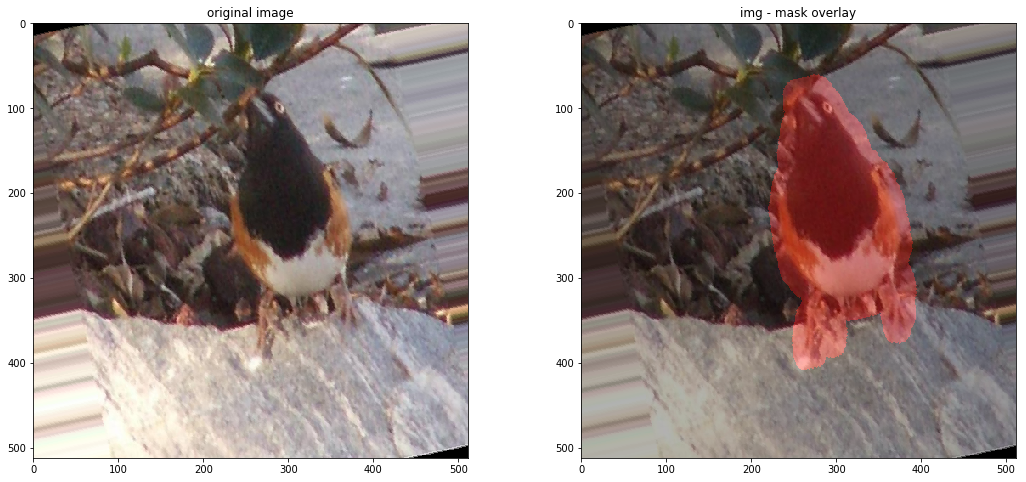

In [19]:
visualize_image_mask(img, msk)

## Step 2: Network Architecture
In this implementation, the network architecture is not the focus, therefore, we are going to create something out of the blue :), how about a combination of resnet50 and Unet that can do both classification and segmentation? we can call it - ResUnet50 

In [7]:
def ResUnet50(input_shape=(512, 512, 3), num_classes=200):
    inputs = layers.Input(shape=input_shape)
    resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling=None, input_tensor=inputs)
    assert resnet50.layers[4].name == "conv1_relu"
    C1 = resnet50.layers[4].output  # 256 x 256 x 64
    assert resnet50.layers[38].name == "conv2_block3_out"
    C2 = resnet50.layers[38].output  # 128 x 128 x 256
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output  # 64 x 64 x 512
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output  # 32 x 32 x 1024
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output  # 16 x 16 x 2048
    #classification subnet
    label = layers.GlobalMaxPool2D()(C5)
    label = layers.Flatten()(label)
    label = layers.Dense(num_classes, activation='softmax')(label)
    #segmentation subnet
    conv_config = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
    up6 = layers.Conv2D(512, 3, **conv_config)(layers.UpSampling2D(size=(2, 2))(C5))  # 32 x 32 x 512
    merge6 = layers.concatenate([C4, up6], axis=3)  # 32 x 32 x 1536
    conv6 = layers.Conv2D(512, 3, **conv_config)(merge6)  # 32 x 32 x 512
    conv6 = layers.Conv2D(512, 3, **conv_config)(conv6)  # 32 x 32 x 512
    up7 = layers.Conv2D(256, 3, **conv_config)(layers.UpSampling2D(size=(2, 2))(conv6))  # 64 x 64 x 256
    merge7 = layers.concatenate([C3, up7], axis=3)  # 64 x 64 x 768
    conv7 = layers.Conv2D(256, 3, **conv_config)(merge7)  # 64 x 64 x 256
    conv7 = layers.Conv2D(256, 3, **conv_config)(conv7)  # 64 x 64 x 256
    up8 = layers.Conv2D(128, 3, **conv_config)(layers.UpSampling2D(size=(2, 2))(conv7))  # 128 x 128 x 128
    merge8 = layers.concatenate([C2, up8], axis=3)  # 128 x 128 x 384
    conv8 = layers.Conv2D(128, 3, **conv_config)(merge8)  # 128 x 128 x 128
    conv8 = layers.Conv2D(128, 3, **conv_config)(conv8)  # 128 x 128 x 128
    up9 = layers.Conv2D(64, 3, **conv_config)(layers.UpSampling2D(size=(2, 2))(conv8))  # 256 x 256 x 64
    merge9 = layers.concatenate([C1, up9], axis=3)  # 256 x 256 x 128
    conv9 = layers.Conv2D(64, 3, **conv_config)(merge9)  # 256 x 256 x 64
    conv9 = layers.Conv2D(64, 3, **conv_config)(conv9)  # 256 x 256 x 64
    up10 = layers.Conv2D(2, 3, **conv_config)(layers.UpSampling2D(size=(2, 2))(conv9))  # 512 x 512 x 2
    mask = layers.Conv2D(1, 1, activation='sigmoid')(up10)
    model = tf.keras.Model(inputs=inputs, outputs=[label, mask])
    return model

Other than the ResUnet50, we will have another network to contain the trainable weighted parameter in the weighted loss, we call it uncertainty model. In the network `ops`, ResuNet produces both predicted label and predicted mask, then two predictions are feeded to classification loss and segmentation loss. Finally, both losses are used in uncertainty model to create final loss.

In [8]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
resunet50 = fe.build(model_def=ResUnet50, model_name="resunet50", optimizer=opt, loss_name="total_loss")
uncertainty = fe.build(model_def=UncertaintyLoss, model_name="uncertainty", optimizer=opt, loss_name="total_loss")
network = fe.Network(ops=[
    ModelOp(inputs='image', model=resunet50, outputs=["label_pred", "mask_pred"]),
    SparseCategoricalCrossentropy(inputs=["label", "label_pred"], outputs="cls_loss"),
    BinaryCrossentropy(inputs=["annotation", "mask_pred"], outputs="seg_loss"),
    ModelOp(inputs=("cls_loss", "seg_loss"), model=uncertainty, outputs="total_loss"),
    Loss(inputs="total_loss", outputs="total_loss")
])

## Step3: Estimator

We will have four different traces to control/monitor the training, Dice and Accuracy will be used to measure segmentation and classification results, Model saver will save the model with best loss, LR controller will apply a cosine learning rate decay throughout the training loop

In [9]:
model_dir=tempfile.mkdtemp()

traces = [
    Dice(true_key="annotation", pred_key='mask_pred'),
    Accuracy(true_key="label", pred_key="label_pred"),
    ModelSaver(model_name="resunet50", save_dir=model_dir, save_best=True),
    LRController(model_name="resunet50", lr_schedule=CyclicLRSchedule())
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         traces=traces,
                         epochs=epochs,
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps)

## Start training

the whole training (25 epochs) will take about 1 hour on single V100 GPU. We are going to reach ~0.86 dice and ~75% accuracy by the end of the training.

In [ ]:
estimator.fit()

## Inferencing

In [14]:
model_dir = "/data/Xiaomeng"

In [15]:
modelfile = os.path.join(model_dir, "resunet50_best_total_loss.h5")

In [16]:
model = tf.keras.models.load_model(modelfile)

In [21]:
predicted_results = model.predict(img_batch)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv1_conv_1/Conv2D (defined at /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_17244]

Function call stack:
keras_scratch_graph
